In [9]:
import numpy as np 
from keras.models import * 
from keras.layers import * 
from keras.optimizers import * 
from keras.datasets import mnist 
import keras.backend as K 
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm
%matplotlib inline

K.set_image_data_format('channels_last') 

In [10]:
class Gan: 
    def __init__(self, img_data): 
        img_size = img_data.shape[1] 
        channel = img_data.shape[3] if len(img_data.shape) >= 4 else 1 
        
        self.img_data = img_data 
        self.input_shape = (img_size, img_size, channel) 
        
        self.img_rows = img_size 
        self.img_cols = img_size 
        self.channel = channel 
        self.noise_size = 100 
        
        self.create_d() 
        self.create_g() 
        
        # Build model to train D.
        optimizer = Adam(lr=0.0008) 
        self.D.compile(loss='binary_crossentropy', optimizer=optimizer) 
        
        # Build model to train G.
        optimizer = Adam(lr=0.0004) 
        self.D.trainable = False 
        self.AM = Sequential() 
        self.AM.add(self.G) 
        self.AM.add(self.D) 
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.AM.summary()
    
    def create_d(self): 
        self.D = Sequential() 
        depth = 64 
        dropout = 0.4 
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=self.input_shape, padding='same')) 
        self.D.add(LeakyReLU(alpha=0.2)) 
        self.D.add(Dropout(dropout)) 
        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same')) 
        self.D.add(LeakyReLU(alpha=0.2)) 
        self.D.add(Dropout(dropout)) 
        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same')) 
        self.D.add(LeakyReLU(alpha=0.2)) 
        self.D.add(Dropout(dropout)) 
        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same')) 
        self.D.add(LeakyReLU(alpha=0.2)) 
        self.D.add(Dropout(dropout)) 
        self.D.add(Flatten()) 
        self.D.add(Dense(1)) 
        self.D.add(Activation('sigmoid')) 
        #self.D.summary() 
        return self.D 
        
    def create_g(self): 
        self.G = Sequential() 
        dropout = 0.4 
        depth = 64+64+64+64 
        dim = 7 
        self.G.add(Dense(dim*dim*depth, input_dim=self.noise_size)) 
        self.G.add(BatchNormalization(momentum=0.9)) 
        self.G.add(Activation('relu')) 
        self.G.add(Reshape((dim, dim, depth))) 
        self.G.add(Dropout(dropout)) 
        self.G.add(UpSampling2D()) 
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same')) 
        self.G.add(BatchNormalization(momentum=0.9)) 
        self.G.add(Activation('relu')) 
        self.G.add(UpSampling2D()) 
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same')) 
        self.G.add(BatchNormalization(momentum=0.9)) 
        self.G.add(Activation('relu')) 
        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same')) 
        self.G.add(BatchNormalization(momentum=0.9)) 
        self.G.add(Activation('relu')) 
        self.G.add(Conv2DTranspose(1, 5, padding='same')) 
        self.G.add(Activation('sigmoid')) 
        #self.G.summary() 
        return self.G 
        
    def train(self, batch_size=100): 
        # 60000개의 MNIST x_train Data에서 batch_size 만큼 랜덤 추출 
        images_train = self.img_data[np.random.randint(0, self.img_data.shape[0], size=batch_size), :, :, :] 
        
        # -1~ 1 사이의 분포된 100개의 100차원의 랜덤값 
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size]) 
        # Generator 평가는 noise 데이터로 (가짜데이터)
        images_fake = self.G.predict(noise) 
         
        # Train D 진짜와 가짜를 한번에 셋팅
        x = np.concatenate((images_train, images_fake)) 
        # batch_size 만큼의 진짜와 가짜를 이어서 200개 의 1 이라는 y(label) 생성
        y = np.ones([2*batch_size, 1]) 
        # 100개~ 뒤 까지는 images_fake 데이터이니까 0 으로 설정
        y[batch_size:, :] = 0 
        # 학습설정 True
        self.D.trainable = True
        # x(진짜+가짜) y(진짜라벨+가짜라벨) 에 대한 한번의 loss값 
        d_loss = self.D.train_on_batch(x, y) 
        
        # AM을 학습
        y = np.ones([batch_size, 1]) # 100개는 1 
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size]) 
        # AM을 학습진행할때는 Dicriminator는 학습 False
        self.D.trainable = False 
        # 입력의 noise는 전부 가짜(1)라고 학습 
        a_loss = self.AM.train_on_batch(noise, y) 
        return d_loss, a_loss, images_fake

    def save(self): 
        self.G.save('gan_g_model.h5') 
        self.D.save('gan_d_model.h5')

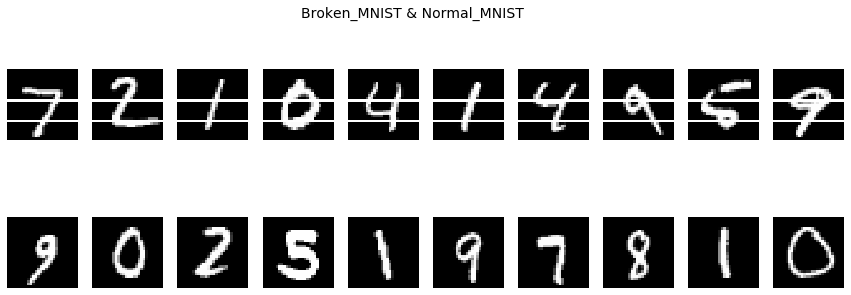

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 2,368,705
Non-trainable params: 4,337,089
_________________________________________________________________


In [11]:
# MNIST dataset load
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train 0~1 normalization & reshape
x_train = x_train.reshape((x_train.shape[0],) + (28, 28, 1)).astype('float32') 
x_train = x_train / 255. 

# x_test 0~1 normalization & reshape
x_test = x_test.reshape((x_test.shape[0],) + (28, 28, 1)).astype('float32') 
x_test = x_test / 255. 

# broken MNIST & nomarl MNIST
fail_test = x_test[ :1000].copy()
real_test = x_test[1000:2000].copy()
fail_test[: , 12 , :] = 1.
fail_test[: , 20 , :] = 1.

# cross fail_test_set
# fail_test[:,3,5:15] = 1
# fail_test[:,1:10,5:10] = 1

fig, axs = plt.subplots(2,10, figsize=(15, 5))
for i in range(10) :
    fig.suptitle('Broken_MNIST & Normal_MNIST', fontsize=14)
    axs[0, i].set_axis_off()
    axs[0, i].imshow(fail_test[i].reshape(28,28), cmap='gray')
    axs[1, i].set_axis_off()
    axs[1, i].imshow(real_test[i].reshape(28,28), cmap='gray')
plt.show()
plt.close(fig)

# Init network 
gan = Gan(x_train) 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1
D Loss: 0.28605468499716474, AM Loss: 2.885741405022915


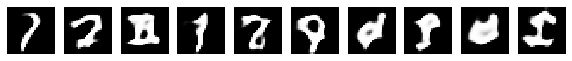

  3%|▎         | 1/30 [01:34<45:39, 94.48s/it]

Epoch: 2
D Loss: 0.39292957102259, AM Loss: 2.1113878854115806


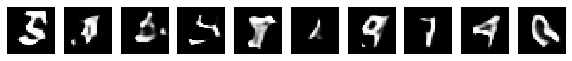

  7%|▋         | 2/30 [03:03<43:17, 92.76s/it]

Epoch: 3
D Loss: 0.4512727679312229, AM Loss: 1.6962681500116985


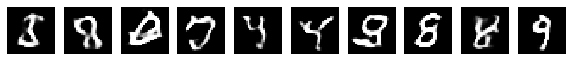

 10%|█         | 3/30 [04:31<41:12, 91.56s/it]

Epoch: 4
D Loss: 0.46483253757158915, AM Loss: 1.653689972559611


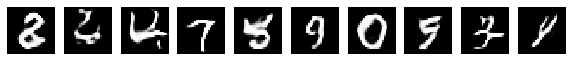

 13%|█▎        | 4/30 [06:00<39:18, 90.72s/it]

Epoch: 5
D Loss: 0.47984681849678357, AM Loss: 1.5942910707990328


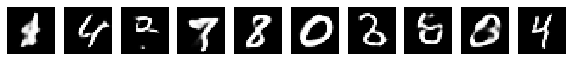

 17%|█▋        | 5/30 [07:29<37:33, 90.14s/it]

Epoch: 6
D Loss: 0.5108137092987697, AM Loss: 1.426555556555589


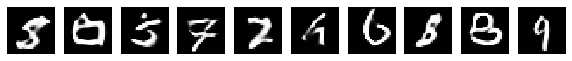

 20%|██        | 6/30 [08:58<35:54, 89.77s/it]

Epoch: 7
D Loss: 0.5325348347922166, AM Loss: 1.3608728485306103


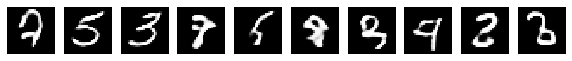

 23%|██▎       | 7/30 [10:27<34:19, 89.55s/it]

Epoch: 8
D Loss: 0.5321448629597822, AM Loss: 1.4219719005624454


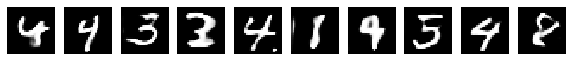

 27%|██▋       | 8/30 [11:56<32:45, 89.32s/it]

Epoch: 9
D Loss: 0.5555266999204953, AM Loss: 1.253095022837321


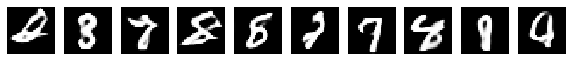

 30%|███       | 9/30 [13:25<31:12, 89.15s/it]

Epoch: 10
D Loss: 0.5571435390909513, AM Loss: 1.2686510519186656


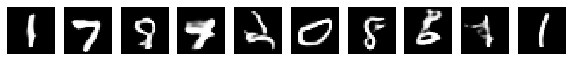

 33%|███▎      | 10/30 [14:53<29:40, 89.05s/it]

Epoch: 11
D Loss: 0.5619119687378407, AM Loss: 1.2278563284873962


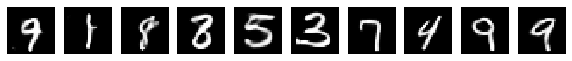

 37%|███▋      | 11/30 [16:22<28:10, 88.99s/it]

Epoch: 12
D Loss: 0.5725069469213486, AM Loss: 1.1869395147760708


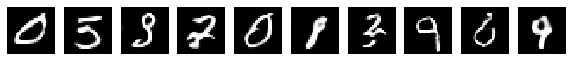

 40%|████      | 12/30 [17:51<26:41, 88.96s/it]

Epoch: 13
D Loss: 0.5743058001498381, AM Loss: 1.2012351044019063


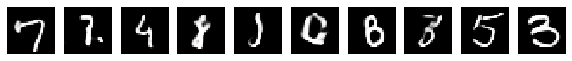

 43%|████▎     | 13/30 [19:20<25:11, 88.90s/it]

Epoch: 14
D Loss: 0.5699868221580983, AM Loss: 1.2533033604423205


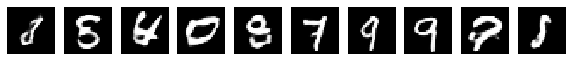

 47%|████▋     | 14/30 [20:49<23:41, 88.87s/it]

Epoch: 15
D Loss: 0.5771680151919524, AM Loss: 1.1866183364391327


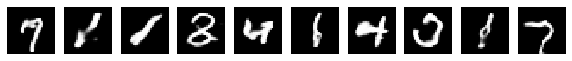

 50%|█████     | 15/30 [22:17<22:12, 88.83s/it]

Epoch: 16
D Loss: 0.5831499582032362, AM Loss: 1.1635600288709005


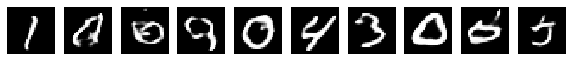

 53%|█████▎    | 16/30 [23:46<20:42, 88.78s/it]

Epoch: 17
D Loss: 0.5955953352153301, AM Loss: 1.10213832984368


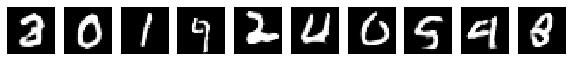

 57%|█████▋    | 17/30 [25:15<19:13, 88.74s/it]

Epoch: 18
D Loss: 0.5977750299870968, AM Loss: 1.115620766679446


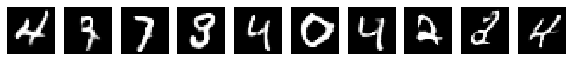

 60%|██████    | 18/30 [26:44<17:45, 88.81s/it]

Epoch: 19
D Loss: 0.6078850468993187, AM Loss: 1.0685753908753395


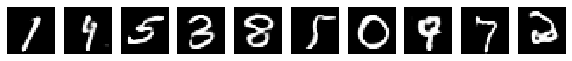

 63%|██████▎   | 19/30 [28:12<16:16, 88.79s/it]

Epoch: 20
D Loss: 0.6086796013514201, AM Loss: 1.0567753290136654


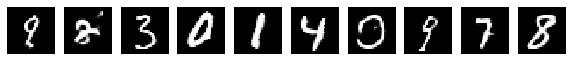

 67%|██████▋   | 20/30 [29:41<14:47, 88.78s/it]

Epoch: 21
D Loss: 0.615709300438563, AM Loss: 1.066863574385643


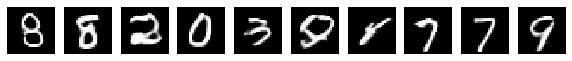

 70%|███████   | 21/30 [31:10<13:18, 88.74s/it]

Epoch: 22
D Loss: 0.6172102179129918, AM Loss: 1.0385571055610974


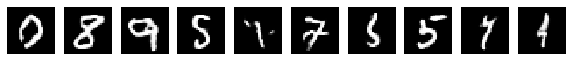

 73%|███████▎  | 22/30 [32:39<11:49, 88.75s/it]

Epoch: 23
D Loss: 0.6240511943896612, AM Loss: 1.0230319728453954


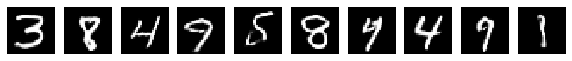

 77%|███████▋  | 23/30 [34:07<10:20, 88.69s/it]

Epoch: 24
D Loss: 0.6245297921697298, AM Loss: 1.009197033047676


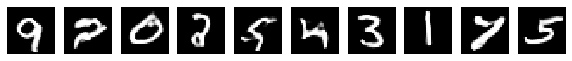

 80%|████████  | 24/30 [35:36<08:52, 88.69s/it]

Epoch: 25
D Loss: 0.6313964099685351, AM Loss: 1.0007955794533094


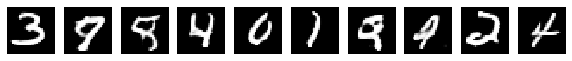

 83%|████████▎ | 25/30 [37:04<07:23, 88.67s/it]

Epoch: 26
D Loss: 0.6311917451520761, AM Loss: 1.0230263072252272


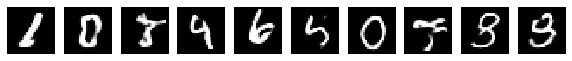

 87%|████████▋ | 26/30 [38:33<05:54, 88.66s/it]

Epoch: 27
D Loss: 0.6320237938563029, AM Loss: 0.9903878299395243


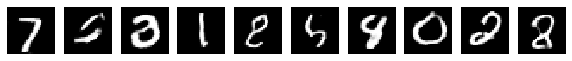

 90%|█████████ | 27/30 [40:02<04:25, 88.64s/it]

Epoch: 28
D Loss: 0.6375410958131155, AM Loss: 0.9695681399106979


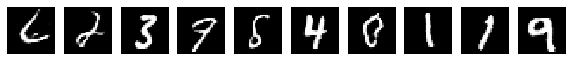

 93%|█████████▎| 28/30 [41:30<02:57, 88.66s/it]

Epoch: 29
D Loss: 0.6421918549140294, AM Loss: 0.9682490916053454


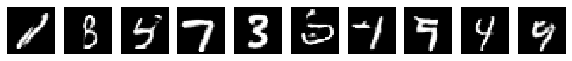

 97%|█████████▋| 29/30 [42:59<01:28, 88.77s/it]

Epoch: 30
D Loss: 0.6417028919855754, AM Loss: 0.9680319463213285


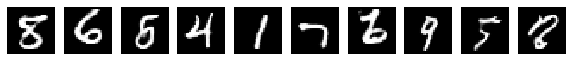

100%|██████████| 30/30 [44:28<00:00, 88.96s/it]


In [4]:
# Some parameters. 
epochs = 30
sample_size = 10 
batch_size = 100 
train_per_epoch = x_train.shape[0] // batch_size 
history=[]

# 학습 
for epoch in tqdm(range(0, epochs)): 
    print("Epoch:", epoch + 1) 
    
    # loss 초기화
    total_d_loss = 0.0
    total_a_loss = 0.0 
    
    # train_per_epoch = 60000 // 100
    for batch in range(0, train_per_epoch): 
        d_loss, a_loss, imgs = gan.train(batch_size) 
        total_d_loss += d_loss # d_loss sum 
        total_a_loss += a_loss # a_loss sum 
        
    # train_per_epoch average loss
    total_d_loss /= train_per_epoch 
    total_a_loss /= train_per_epoch 
    
    # history recode
    recode =(epoch, total_d_loss, total_a_loss)
    history.append(recode)

    print("D Loss: {}, AM Loss: {}".format(total_d_loss, total_a_loss)) 
    

    # image 
    fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1)) 
    for i in range(0, sample_size): 
        ax[i].set_axis_off() 
        ax[i].imshow(imgs[i].reshape((28, 28)), cmap='gray')
    plt.show() 
    plt.close(fig)
    
    # 1 epoch weights save
    gan.save()
    

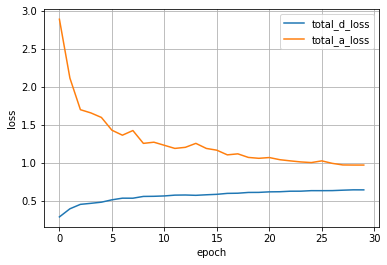

In [5]:
# loss grath
from pandas import DataFrame
import pandas as pd 

df = DataFrame(history, columns=['epoch', 'total_d_loss', 'total_a_loss'])

df.plot(y=['total_d_loss', 'total_a_loss'])
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.close()

load


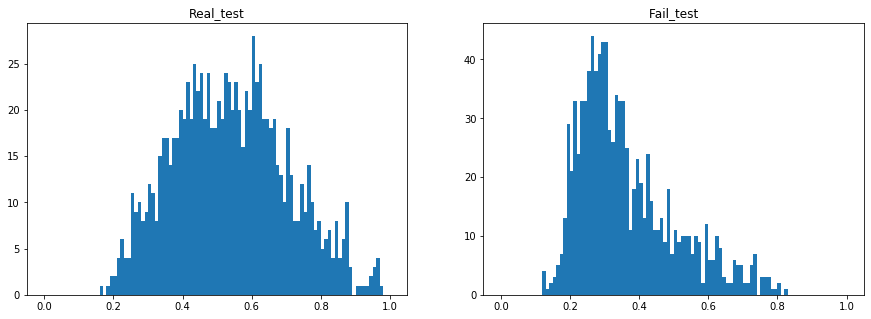

실제 MNIST일 확률은 56.99999999999999%입니다.
불량 MNIST일 확률은 82.69999999999999%입니다.


In [13]:
dis = load_model('gan_d_model.h5')
print('Model load')

predictions_real = dis.predict(real_test)
predictions_fail = dis.predict(fail_test)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title('Real_test')
ax1.hist(predictions_real, range=(0,1), bins=100)
ax2.set_title('Fail_test')
ax2.hist(predictions_fail, range=(0,1),bins=100)
plt.show()
plt.close()


len_real = len(predictions_real)
len_fail = len(predictions_fail)
list_real=[]
list_fail=[]

for i in range(len_real) : 
    if predictions_real[i] >= 0.5 : 
        list_real.append(predictions_fail[i])
print('실제 MNIST일 확률은 ' + str((len(list_real) / len_real) *100) + '%입니다.')

for i in range(len_fail) : 
    if predictions_fail[i] <= 0.5 : 
        list_fail.append(predictions_fail[i])
print('불량 MNIST일 확률은 ' + str((len(list_fail) / len_fail) * 100) + '%입니다.')

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


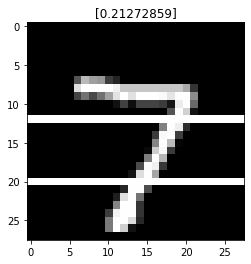

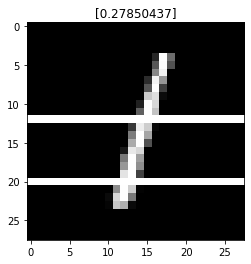

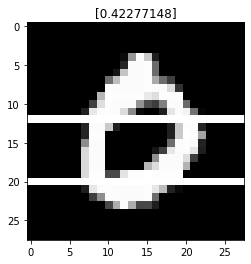

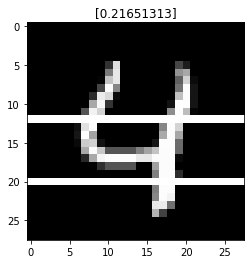

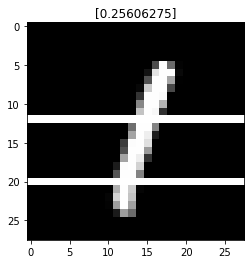

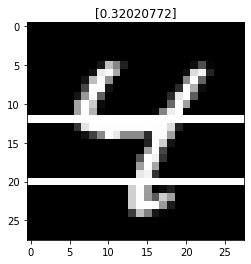

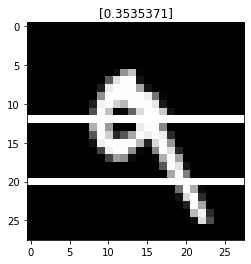

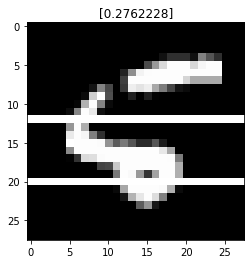

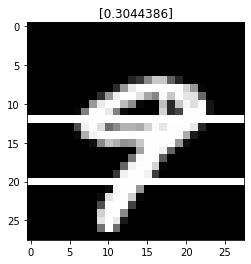

In [7]:
for i in range(10) : 
    if predictions_fail[i] < 0.5 : 
        plt.imshow(fail_test[i].reshape(28,28), cmap='gray')
        plt.title(predictions_fail[i])
        plt.show()
        plt.close()